<a href="https://colab.research.google.com/github/martchfr/h501-gutenberg/blob/master/Week_6_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Singular Value Decomposition

In [ ]:
# @title \<imports>
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.linalg as mat

from skimage import io, color, transform
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set_style('white')
%config InlineBackend.figure_formats = ['svg']

np.set_printoptions(suppress=True)

# Situation 1 : PCA

In this notebook, we'll use a collection of speeches by U.S. presidents, gathered from [The Miller Center](https://millercenter.org/the-presidency/presidential-speeches). In particular, we'll select only those speeches made since the election of President George W. Bush (i.e., 2000).

In [ ]:
# @title \<gather speeches from 21st century>
df_speeches = pd.read_csv("https://raw.githubusercontent.com/leontoddjohnson/datasets/main/text/presidential_speeches.csv")
df_speeches['date'] = pd.to_datetime(df_speeches['date'], errors='coerce')
df_speeches['date'].dropna(inplace=True)
mask = df_speeches['date'].dt.year >= 2000

df_speeches[mask].sample(5)

,doc_name,date,transcript,president,title
712,june-20-2020-campaign-rally-tulsa-oklahoma,2020-06-20,"Thank you, thank you. So we begin, Oklahoma, w...",Donald Trump,"June 20, 2020: Campaign Rally in Tulsa, Oklahoma"
481,august-16-2021-remarks-situation-afghanistan,2021-08-16,THE PRESIDENT: Good afternoon. I want to speak...,Joe Biden,"August 16, 2021: Remarks on Situation in Afgha..."
295,september-6-2012-nominee-acceptance-speech-201...,2012-09-06,THE PRESIDENT: Thank you. (Applause.) Thank...,Barack Obama,"September 6, 2012: Nominee Acceptance Speech a..."
864,march-11-2020-statement-coronavirus,2020-03-12,"My fellow Americans: Tonight, I want to speak ...",Donald Trump,"March 11, 2020: Statement on the Coronavirus"
1047,december-16-2012-remarks-sandy-hook-elementary...,2012-12-16,"Thank you. (Applause.) Thank you, Governor. ...",Barack Obama,"December 16, 2012: Remarks on Sandy Hook Eleme..."


For each speech (in the `transcript` column), we'll count the number of times each word is used, and create a document-term matrix, as we've seen in a previous exercise. So, each row will index a speech, and each column will index a word that could have been used in that speech. The values will be the number of times each word was used in each speech.

*Note: for this notebook, we'll only include words that occur in at least 50% of the documents. I.e., rare words like "abolitionism" won't be included below.*

In [ ]:
# @title \<create doc-term matrix>
cv = CountVectorizer(ngram_range=(1, 1),
                     max_df=1.0,
                     min_df=0.5,          # only the most popular words, for variety.
                     max_features=None,
                     binary=False)

X = cv.fit_transform(df_speeches[mask]["transcript"].values)

df = pd.DataFrame(X.toarray(),
                  index=df_speeches[mask]['doc_name'],
                  columns=cv.get_feature_names_out())

print("Shape of doc-term matrix = ", df.shape)

Shape of doc-term matrix =  (155, 353)


So, there are 155 speeches and 353 "frequently used" terms, and we'll call this matrix $D$.

For this analysis, we'll concern ourselves only with the number of times the following words are used:

- **"America"**
- **"American"**

Interestingly, these two words capture two different ways of thinking about the country: either, we're focused on the nation as an entity (i.e., "America"), or each individual within it (i.e., an "American").

<font color='darkred'>Note: we are completely removing the other words (columns), so each row is now **strictly** defined by the number of times these two words are used.</font>

In [ ]:
# @title \<get data>
terms = ['america', 'american']

df_X = df[terms]
df_X.head()

,america,american
doc_name,,
march-19-2008-remarks-war-terror,13,10
october-26-2020-swearing-ceremony-honorable-amy-coney-barrett,8,6
january-20-2005-second-inaugural-address-0,20,2
january-19-2021-farewell-address,24,18
september-9-2021-remarks-fighting-covid-19-pandemic,8,7


In [ ]:
df_X.shape

(155, 2)

This matrix has $n=155$ rows and $k=2$ columns, and we'll call this matrix $X$, the main data for this situation.

Recall the singular values for a matrix $A$ are the square roots of the *eigenvalues* of $A^\top A$. To relate this matrix back to $X$ in a convenient way, we will create a new matrix $A$:

1. Subtract each value in $X$ by its corresponding column average ($\bar{\mathbf{x}}_j$). *This is called "centering" the data.*
2. Divide this quantity by the corresponding column standard deviation ($\sigma_j$).

So, each column of $A$ has an average of of 0, and an equal standard deviation of 1. Then, the $i$th row and $j$th column in $A$ is:

$$
A_{ij}
= \frac{x_{ij} - \bar{\mathbf{x}}_j}{\sigma_j}
$$

Now, we can calculate each element of $A^\top A$:

$$
\left[A^\top A\right]_{ij} = \left(\frac{\mathbf{x}_i - \mathbf{\bar{x}}_i}{\sigma_i}\right)\cdot\left(\frac{\mathbf{x}_j - \mathbf{\bar{x}}_j}{\sigma_j}\right)
$$

If we divide each of these values by the number of rows of data $n$ minus 1, then we arrive at the [correlation](https://en.wikipedia.org/wiki/Correlation) between column $i$ and column $j$ (which we will discuss in more detail in a different lesson).

$$
\begin{aligned}
\frac{1}{n-1}\left[A^\top A\right]_{ij} &= \text{corr}(\mathbf{x}_i, \mathbf{x}_j)
\end{aligned}
$$

Now, let's consider $A^\top A$.

In [ ]:
# @title \<calculate $A^\top A$>
df_A = (df_X - df_X.mean()) / df_X.std()
ata = df_A.values.T @ df_A.values
ata

array([[154.        , 102.19752438],
       [102.19752438, 154.        ]])

We'll calculate the eigenvalues and eigenvectors of this matrix.

In [ ]:
# @title \<calculate eigenvalues/vectors>
eigvals, eigvecs = mat.eig(ata)

In [ ]:
eigvals

array([ 51.80247562, 256.19752438])

In [ ]:
eigvecs

array([[-0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678]])

In [ ]:
# note the fractional form ...
1 / np.sqrt(2)

0.7071067811865475

When we compute the singular value decomposition (SVD) of a matrix, singular values are typically presented in descending order. So, we'll follow suit here by sorting the eigenvalues and eigenvectors accordingly.

In [ ]:
# @title \<sort eigenvalues/vectors>
idx = np.argsort(eigvals)[::-1]
sorted_eigvals = eigvals[idx]
sorted_eigvecs = eigvecs[:, idx]

In [ ]:
sorted_eigvals

array([256.19752438,  51.80247562])

In [ ]:
sorted_eigvecs

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

We can call this sorted matrix of eigenvectors $V$.

Let's also plot our scaled data $A$ against the lines defined by these (sorted) eigenvectors.

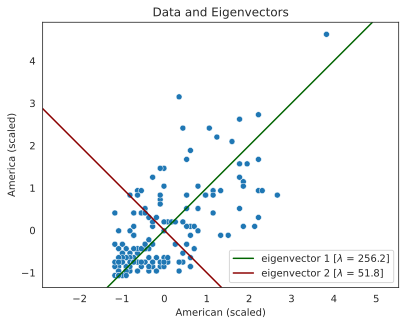

In [ ]:
# @title \<plot eigenvectors>
sns.scatterplot(data=df_A, x="america", y="american");

plt.axline((0, 0), sorted_eigvecs[:, 0],
           label=f'eigenvector 1 [$\lambda$ = {round(sorted_eigvals[0], 1)}]',
           color='darkgreen')

plt.axline((0, 0), sorted_eigvecs[:, 1],
           label=f'eigenvector 2 [$\lambda$ = {round(sorted_eigvals[1], 1)}]',
           color='darkred')

plt.axis('equal')  # square the axes to show perpendicular eigenvectors
plt.xlabel('American (scaled)')
plt.ylabel('America (scaled)')
plt.legend(loc='lower right')
plt.title("Data and Eigenvectors");

In the context of [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), these eigenvectors ($V$) are called **principal components**, or "principal axes." Consider the result of multiplying $AV$. In other words, we use the orthonormal basis vectors $V$ to project the rows of $A$ onto the principal component axes.

*(Below, we have just the first 10 rows.)*

In [ ]:
av = df_A.values @ sorted_eigvecs
print(av[:10].round(2))

[[ 0.02 -0.  ]
 [ 0.63  0.02]
 [ 0.17 -1.04]
 [-1.27 -0.1 ]
 [ 0.55  0.09]
 [ 0.07 -0.69]
 [-3.5   0.36]
 [ 0.05 -0.41]
 [-0.35 -0.52]
 [-1.48 -0.15]]


When we multiply the [variance](https://en.wikipedia.org/wiki/Variance) of these columns by $n-1$, we arrive at the same eigenvalues of $A^\top A$. In other words, the numerator of the variance calculation for $AV$ is equivalent to finding the eigenvalues for $A^\top A$, and **the eigenvalues are proportional to the variance of the data *along* the "principal axes."**

In [ ]:
n = df_A.shape[0]
av.var(ddof=1, axis=0) * (n - 1)

array([256.19752438,  51.80247562])

The **Explained Variance Ratio**
indicates the proportion of the total variance captured in or "explained by" each principal component. It provides insight into the "significance" of each component in capturing the variability within the dataset. This is calculated by dividing each eigenvalue by the sum of all the eigenvalues.

In [ ]:
# @title \<variance explained>
total_variance = np.sum(sorted_eigvals)
explained_variance_ratio = sorted_eigvals / total_variance

print("\nExplained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio:.2%}")


Explained Variance Ratio:
Principal Component 1: 83.18%
Principal Component 2: 16.82%


In other words, roughly 83% of the variance of the data is captured by moving along the green line in the plot above. This green line (the first eigenspace) represents one particular *linear combination* of "america" and "american", defining each row in this way. If we *only* used this first linear combination to define each row, the differences drawn between each speech (i.e., each row) would be roughly 83% accurate. The perpendicular red line accounts for a completely different "viewpoint", namely another linear combination of the two which accounts for the remaining 17% of the variance in the data.

**Consider the remaining terms ...**

Let's run singular value decomposition on the full doc-term matrix, $D$, with all 155 speeches and all 353 frequently used terms.

In [ ]:
U, Sigma, Vt = np.linalg.svd(df, full_matrices=False)

The range of singular values here is:

In [ ]:
print(f"min = {round(Sigma[-1], 2)}, max = {round(Sigma[0], 2)}")

min = 1.08, max = 5724.27


# Situation 2

Consider the following image, where each pixel corresponds to a numeric "gray-level".

In [ ]:
# pip install scikit-image

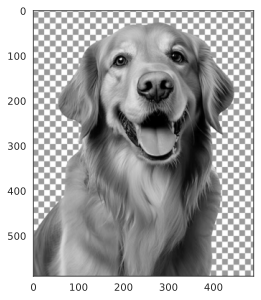

In [ ]:
# @title \<get image>
image_path = "https://raw.githubusercontent.com/leontoddjohnson/datasets/main/images/dog.png"
image = io.imread(image_path, as_gray=True)

plt.imshow(image, cmap='gray');

In [ ]:
# size of the image *matrix*
image.shape

(590, 490)

Let us call this matrix $M$. Now, let's directly apply Singular Value Decomposition to the matrix that defines this image.

In [ ]:
# @title \<apply svd>
U, Sigma, Vt = np.linalg.svd(image, full_matrices=False)

print("Shapes of U, Sigma, Vt:", U.shape, Sigma.shape, Vt.shape)

Shapes of U, Sigma, Vt: (590, 490) (490,) (490, 490)


Recall the calculation for explained variance from above. When we take the cumulative sum of these percentages at each component, we have the **cumulative explained variance**. Consider a plot of these values for the first 200 principal components.

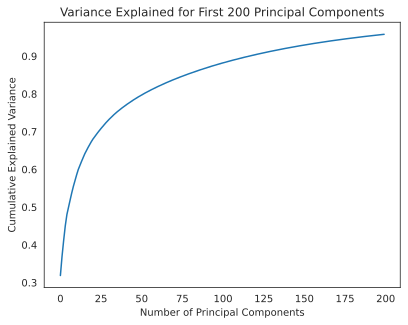

In [ ]:
# @title \<cumulative explained variance>
tot_exp_var = (Sigma / Sigma.sum()).cumsum()

g = sns.lineplot(tot_exp_var[:200])
g.set_title(f"Variance Explained for First 200 Principal Components")
g.set_ylabel("Cumulative Explained Variance")
g.set_xlabel("Number of Principal Components");

Suppose we retain only the top $k = 100$ singular values (and vectors).

In [ ]:
# @title \<truncated SVD>
k = 100
U_reduced = U[:, :k]
Sigma_reduced = np.diag(Sigma[:k])
Vt_reduced = Vt[:k, :]

print("Shapes of U_reduced, Sigma_reduced, Vt_reduced:", U_reduced.shape, Sigma_reduced.shape, Vt_reduced.shape)

Shapes of U_reduced, Sigma_reduced, Vt_reduced: (590, 100) (100, 100) (100, 490)


Now, we'll reconstruct a "compressed" image using these matrices:

$$
\text{Compressed Image} = U' \Sigma' V'^\top
$$

Where each matrix with the $'$ is truncated up to $k$ columns. This is called **Truncated SVD**.

In [ ]:
# @title \<compress image>
compressed_image = np.dot(U_reduced, np.dot(Sigma_reduced, Vt_reduced))
compressed_image_resized = transform.resize(compressed_image, image.shape, mode='constant', anti_aliasing=True)

When we plot these next to eachother, the difference is not so bad ...

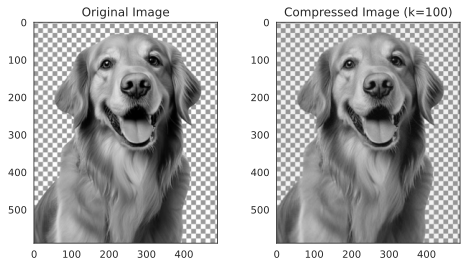

In [ ]:
# @title \<plot images>
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Compressed Image (k={k})")
plt.imshow(compressed_image_resized, cmap='gray')

plt.show()